# Group Chat

Group chat is a design pattern where a group of agents share a common thread
of messages: they all subscribe and publish to the same topic. 
Each participant agent is specialized for a particular task, 
such as writer, illustrator, and editor
in a collaborative writing task.
You can also include an agent to represent a human user to help guide the
agents when needed.

In a group chat, participants take turn to publish a message, and the process
is sequential -- only one agent is working at a time.
Under the hood, the order of turns is maintained by a Group Chat Manager agent,
which selects the next agent to speak upon receving a message.
The exact algorithm for selecting the next agent can vary based on your
application requirements. 
Typically, a round-robin algorithm or a selector with an LLM model is used.

Group chat is useful for dynamically decomposing a complex task into smaller ones 
that can be handled by specialized agents with well-defined roles.
It is also possible to nest group chats into a hierarchy with each participant
a recursive group chat.

In this example, we use AutoGen's Core API to implement the group chat pattern
using event-driven agents.
Please first read about [Topics and Subscriptions](../core-concepts/topic-and-subscription.md)
to understand the concepts and then [Messages and Communication](../framework/message-and-communication.ipynb)
to learn the API usage for pub-sub.
We will demonstrate a simple example of a group chat with a LLM-based selector
for the group chat manager, to create content for a children's story book.

```{note}
While this example illustrates the group chat mechanism, it is complex and
represents a starting point from which you can build your own group chat system
with custom agents and speaker selection algorithms.
The [AgentChat API](../../agentchat-user-guide/index.md) has a built-in implementation
of selector group chat. You can use that if you do not want to use the Core API.
```

We will be using the [rich](https://github.com/Textualize/rich) library to display the messages in a nice format.

In [1]:
# ! pip install rich

In [2]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.base import MessageContext, TopicId
from autogen_core.components import (
    DefaultTopicId,
    FunctionCall,
    Image,
    RoutedAgent,
    TypeSubscription,
    message_handler,
)
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    OpenAIChatCompletionClient,
    SystemMessage,
    UserMessage,
)
from autogen_core.components.tools import FunctionTool
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown

## Message Protocol

The message protocol for the group chat pattern is simple.
1. To start, user or an external agent publishes a `GroupChatMessage` message to the common topic of all participants.
2. The group chat manager selects the next speaker, sends out a `RequestToSpeak` message to that agent.
3. The agent publishes a `GroupChatMessage` message to the common topic upon receiving the `RequestToSpeak` message.
4. This process continues until a termination condition is reached at the group chat manager, which then stops issuing `RequestToSpeak` message, and the group chat ends.

The following diagram illustrates steps 2 to 4 above.

![Group chat message protocol](groupchat.svg)

In [3]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

## Base Group Chat Agent

Let's first define the agent class that only uses LLM models to generate text.
This is will be used as the base class for all AI agents in the group chat.

In [4]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

## Writer and Editor Agents

Using the base class, we can define the writer and editor agents with
different system messages.

In [5]:
class WriterAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )

## Illustrator Agent with Image Generation

Now let's define the `IllustratorAgent` which uses a DALL-E model to generate
an illustration based on the description provided.
We set up the image generator as a tool using {py:class}`~autogen_core.components.tools.FunctionTool`
wrapper, and use a model client to make the tool call.

In [6]:
class IllustratorAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen,
            name="generate_image",
            description="Call this to generate an image given a text description.",
        )

    async def _image_gen(self, description: str) -> str:
        response = await self._image_client.images.generate(
            prompt=description.strip(), model="dall-e-2", response_format="b64_json", size="256x256"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            # print(arguments["description"], flush=True)
            Console().print(Markdown(arguments["description"]))
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## User Agent

With all the AI agents defined, we can now define the user agent that will
take the role of the human user in the group chat.

The `UserAgent` implementation uses console input to get the user's input.
In a real-world scenario, you can replace this by communicating with a frontend,
and subscribe to responses from the frontend.

In [7]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## Group Chat Manager

Lastly, we define the `GroupChatManager` agent which manages the group chat
and selects the next agent to speak using an LLM.
The group chat manager checks if the editor has approved the draft by 
looking for the `"APPORVED"` keyword in the message. If the editor has approved
the draft, the group chat manager stops selecting the next speaker, and the group chat ends.

The group chat manager's constructor takes a list of participants' topic types
as an argument.
To prompt the next speaker to work, 
the it publishes a `RequestToSpeak` message to the next participant's topic.

In this example, we also make sure the group chat manager always picks a different
participant to speak next, by keeping track of the previous speaker.
This helps to ensure the group chat is not dominated by a single participant.

In [8]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

## Creating the Group Chat

To set up the group chat, we create an {py:class}`~autogen_core.application.SingleThreadedAgentRuntime`
and register the agents' factories and subscriptions.

Each participant agent subscribes to both the group chat topic as well as its own
topic in order to receive `RequestToSpeak` messages, 
while the group chat manager agent only subcribes to the group chat topic.

In [9]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

## Running the Group Chat

We start the runtime and publish a `GroupChatMessage` for the task to start the group chat.

Writer:

Title: The Gingerbread Escape                                                                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
In the cozy corner of a quaint, storybook village, nestled between snowy pine trees and bustling with the scent of 
cinnamon and cloves, lived an elderly baker named Mrs. Mortimer. Renowned for her confections, she was the heart of
the village, especially during the Christmas season. One frosty afternoon, she decided to bake something special—a 
gingerbread man unlike any other.                                                                                  

[Illustration: A warm, rustic kitchen filled with jars of spices and the soft glow of a crackling fireplace. Mrs.  
Mortimer, with her rosy cheeks and spectacles perched on her nose, is seen rolling out dough with focused          
determination. Snowflakes gently blanket the world outside her window.]                                            

As if infused with magic, the moment the gingerbread man emerged from the oven, he sprang to life. His eyes, two   
shiny raisins, twinkled with mischief. His mouth, a curve of icing sugar, grinned widely. Before Mrs. Mortimer     
could reach him, he leaped off the baking sheet and dashed out the door.                                           

[Illustration: The gingerbread man mid-air, his icing buttons glistening, as he leaps off a wooden counter. Behind 
him, Mrs. Mortimer's surprised expression captures the moment of unexpected enchantment.]                          

"Run, run, as fast as you can! You can't catch me, I'm the Gingerbread Man!" he taunted, his voice carrying through
the snowy village. Mrs. Mortimer, despite her age, gave chase, her laughter echoing through the streets.           

Down the cobblestone path he sprinted, encountering a group of children building snowmen. Their eyes widened in    
amazement at the cookie on the run. "Catch him!" one shouted, but like a gust of winter wind, he was gone before   
they could even stretch their fingers.                                                                             

[Illustration: A lively winter scene featuring children wearing colorful scarves and mittens as they pause from    
their snow-play to gape at the gingerbread man sprinting past.]                                                    

Next, the gingerbread man sped past a farmer tending to his flock. "Stop, little man!" called the farmer, shaking  
his shovel in surprise. But the gingerbread man only chuckled, his tiny feet kicking up delicate swirls of snow,   
leaving the man and animals staring in wonder.                                                                     

[Illustration: A startled farmer in woolen attire stands in his snowy field, sheep surrounding him, all looking    
towards the gingerbread man as he speeds by. The sky is a brilliant blue, contrasting the white expanse of snow.]  

Onward he ran until he reached the edge of the village, where the river flowed, its icy surface glistening under   
the pale winter sun. A sly fox, watching from the riverbank, licked his lips and called out, "Need help crossing,  
dear gingerbread man?"                                                                                             

Unaware of the fox's intentions, the gingerbread man hesitated, uncertainty flickering in his chocolatey eyes.     
Seeing the baker and villagers in the distance, he nodded, "Yes, I need to be across!"                             

"Hop onto my back," the fox offered, with a cunning smile.                                                         

As they crossed, the waters rose higher. "Climb to my shoulders," the fox suggested. Then as the water's icy       
fingers reached again, "Onto my nose, dear fellow."                                                                

[Illustration: A serene, yet suspenseful r

Illustrator:

A warm, rustic kitchen filled with jars of spices and the soft glow of a crackling fireplace. Mrs. Mortimer, with  
rosy cheeks and spectacles perched on her nose, is seen rolling out dough with focused determination. Snowflakes   
gently blanket the world outside her window.

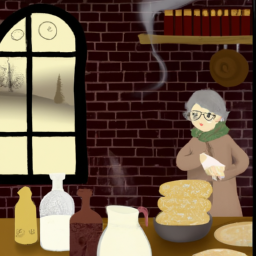

The gingerbread man mid-air, his icing buttons glistening, as he leaps off a wooden counter. Behind him, Mrs.      
Mortimer's surprised expression captures the moment of unexpected enchantment.

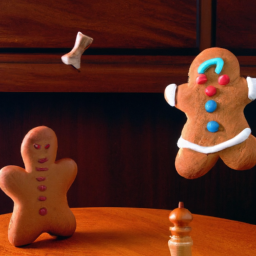

A lively winter scene featuring children wearing colorful scarves and mittens as they pause from their snow-play to
gape at the gingerbread man sprinting past.

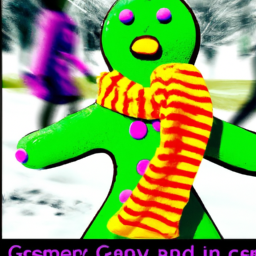

A startled farmer in woolen attire stands in his snowy field, sheep surrounding him, all looking towards the       
gingerbread man as he speeds by. The sky is a brilliant blue, contrasting the white expanse of snow.

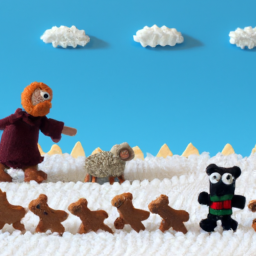

A serene, yet suspenseful river scene. The fox, with his fur glistening, stands mid-river, the gingerbread man     
precariously poised on his nose, steam rising subtly from the flowing water.

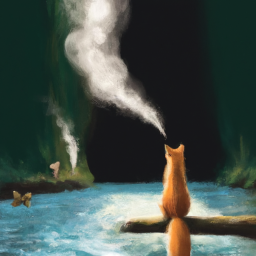

Back in the cozy kitchen, Mrs. Mortimer is busy baking once again. The room is warm and inviting, daylight fading  
outside, leaving a gentle glow inside. On the counter, gingerbread dough waits to be formed, while crumbs of the   
day's adventures seem to linger, cherished in memory.

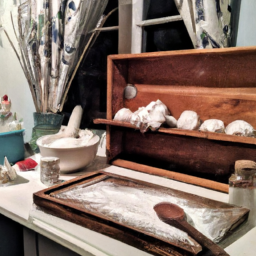

Editor:

The story is charming and well-written, and the illustrations capture the essence of each scene beautifully. Here  
are a few suggestions to enhance the final presentation:                                                           

 1 Coherence and Flow:                                                                                             
    • Make sure the illustrations follow the storyline smoothly. Check if each image matches the narrative context.
 2 Illustration Details:                                                                                           
    • In the second illustration, focus on making the gingerbread man’s leap dynamic yet clear, emphasizing Mrs.   
      Mortimer’s surprise.                                                                                         
    • The third illustration with the children can have a bit more focus on their expressions of amazement.        
 3 Consistency:                                                                                                    
    • Ensure that the style of all illustrations is consistent from beginning to end to maintain a cohesive look.  
 4 Final Scene:                                                                                                    
    • The cozy kitchen scene could use more warmth—soft lighting and gentle shadows can add to the nostalgia.      
 5 Text Placement:                                                                                                 
    • Consider how text might integrate with the illustrations for a seamless experience. Ensure there's space for 
      the text without overlapping important visual details.                                                       

Implement these suggestions for refinement. Let me know when the revisions are ready!

Illustrator:

A warm, rustic kitchen filled with jars of spices and the soft glow of a crackling fireplace. An elderly baker,    
Mrs. Mortimer, with rosy cheeks and glasses, is seen rolling out dough with focused determination. Snow gently     
blankets the world outside the window.

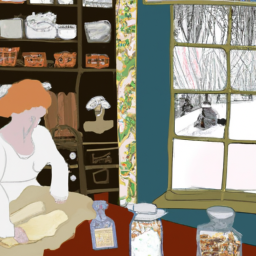

A gingerbread man leaps off a wooden counter, icing buttons glistening, while Mrs. Mortimer looks on in surprise.  
The kitchen backdrop is filled with pots and pans, and a window shows snow falling outside.

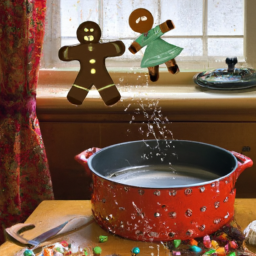

Children in colorful scarves and mittens, pausing their snow-play, gaze in amazement as a gingerbread man rushes   
past. The scene is lively with snowmen and a snow-draped village setting.

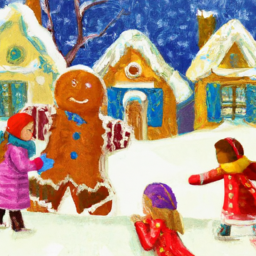

A startled farmer in winter attire stands in a snowy field with sheep looking towards the gingerbread man as he    
speeds by. The sky is bright blue against the white snow landscape.

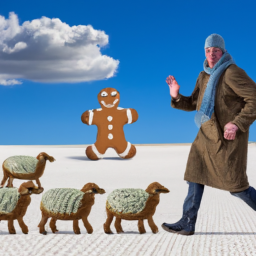

A serene river scene with a fox standing in the water, his fur glistening, while a gingerbread man is poised on his
nose. The icy water flows gently around them.

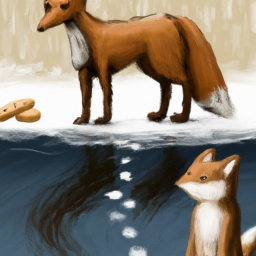

A cozy kitchen with Mrs. Mortimer baking again. The room is warm and inviting with the daylight fading outside.    
Fresh gingerbread dough is on the counter, capturing a nostalgic and warm atmosphere.

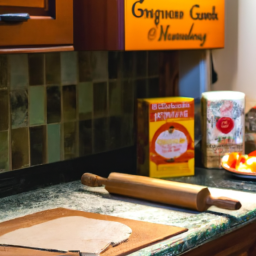

User:                                                       

approve

In [10]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            content="Please write a short story about the gingerbread man with photo-realistic illustrations.",
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()

From the output, you can see the writer, illustrator, and editor agents
taking turns to speak and collaborate to generate a picture book, before
asking for final approval from the user.

## Next Steps

This example showcases a simple implementation of the group chat pattern -- 
**it is not meant to be used in real applications.** You can improve the
speaker selection algorithm. For example, you can avoid using LLM when simple
rules are sufficient and more reliable: 
you can use a rule that the editor always speaks after the writer.

The [AgentChat API](../../agentchat-user-guide/index.md) provides a high-level
API for selector group chat. It has more features but mostly shares the same
design as this implementation.